# Terrestrial Laser Scanning

This notebook is designed to take terrestrial laser scanner (TLS) data from the SnowEx Alaska Campaigns and derive snow depth. The TLS data is provided in both a raw point cloud format and a processed DEM format. For this example, we will be focusing on the TLS DEMs.

The TLS data is available through the cloud on NSIDC and can be accessed using the `earthaccess` package. For this tutorial, we'll use pre-selected data hosted on S3 for simplicity, which allows the notebook to run without authentication. We'll also show you how to access the full dataset using `earthaccess` if you want to explore more data on your own.

The first example will involve a single TLS image for simplicity, then we will have a second example that examines multiple TLS scans from the campaigns.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import re
import rioxarray as rxr
import xarray as xr

The TLS data was gathered in Bonanza Creek near Fairbanks, AK in two months: October 2022 and March 2023. These months correspond to the snow-off and snow-on seasons, respectively. We will start by getting some sample snow-on TLS data from a single day.

## Data Access

For this tutorial, we'll stream data directly from an S3 bucket, which doesn't require authentication. If you want to access the full dataset from NSIDC using `earthaccess`, see the section at the end of this notebook.

In [5]:
# Define S3 URLs for TLS data
S3_BASE_URL = "https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls"

# Single scan example - snow-on (March 15, 2023) and snow-off (October 25, 2022)
# Using CRS3 site which has data from both periods
snow_on_url = f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230315_CRS3_V01.0.tif"
snow_off_url = f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221025_CRS3_V01.0.tif"

print("✓ S3 URLs configured for streaming TLS data")

✓ S3 URLs configured for streaming TLS data


Because the TLS data is available on-demand through the cloud, we do not need to download it. Instead, we can stream it directly with `rioxarray`!

In [6]:
# Load a single TLS scan from S3
snow_on = rxr.open_rasterio(snow_on_url)

In [7]:
snow_on.rio.width

455

Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20230315_CRS3_V01.0.tif.msk: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20230315_CRS3_V01.0.tif.MSK: 403


Text(0.5, 1.0, ' ')

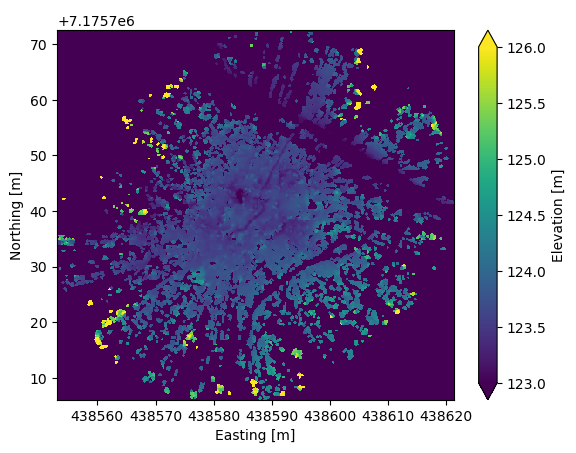

In [8]:
# Visualize the snow-on data
fig, ax = plt.subplots()
snow_on.plot(ax=ax, vmin=123, vmax=126,
             cbar_kwargs={'label': "Elevation [m]"})
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_title(" ")

Two things are noticeable from this TLS data:
1. It has a very high resolution (0.15 m).
2. The signal attenutates after ~60 m, so we have a small field of view.

This suggests that we will be able to obtain very fine-scale measurements of snow depth, but we will need scans from multiple locations to better characterize snow in Bonanza Creek.

In any case, let's grab the snow-off data from the same location, and try to derive snow depth.

In [9]:
# Load the corresponding snow-off scan from S3
snow_off = rxr.open_rasterio(snow_off_url)

Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20221025_CRS3_V01.0.tif.msk: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20221025_CRS3_V01.0.tif.MSK: 403


Text(0.5, 1.0, ' ')

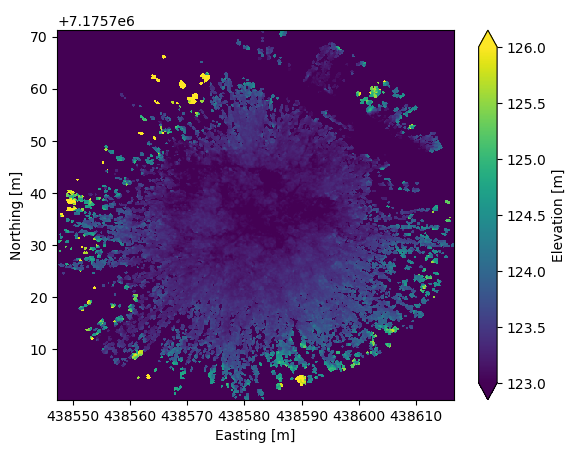

In [10]:
fig, ax = plt.subplots()
snow_off.plot(vmin=123, vmax=126,
              cbar_kwargs={'label': "Elevation [m]"})
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_title(" ")

Although the snow-on/-off data look similar to each other, there are slight differences, meaning that we cannot perform a difference right away. We must first interpolate the data, ensuring that fill values are accounted for, then perform the difference.

In [11]:
# Interpolate snow-on data onto the x/y grid of snow-off data
snow_on_interp = snow_on.interp(
    x=snow_off.x,
    y=snow_off.y,
    kwargs={"fill_value": snow_on.attrs.get('_FillValue', np.nan)}
)

# Calculate the difference (snow depth)
difference = snow_on_interp - snow_off

# Define fill values in data
fill = snow_off.attrs.get('_FillValue', -9999.0)

# Include only data that is not equal to the fill value
difference = difference.where((snow_off != fill) & (snow_on_interp != fill))

Text(0.5, 1.0, ' ')

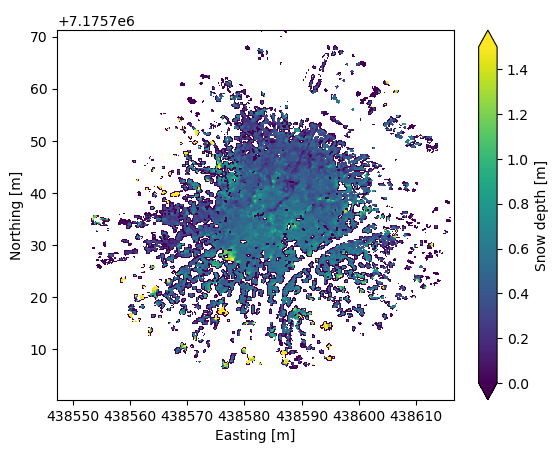

In [12]:
# Plot snow depth over the TLS scene
fig, ax = plt.subplots()
difference.plot(vmin=0, vmax=1.5,
                cbar_kwargs={'label': "Snow depth [m]"})
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_title(" ")

Although not perfect, this provides a very reasonable snow depth DEM for the TLS data gathered in this location. If we want, we can perform basic statistics on the derived snow depths.

Text(1, 8000, 'Median depth = 0.49 m')

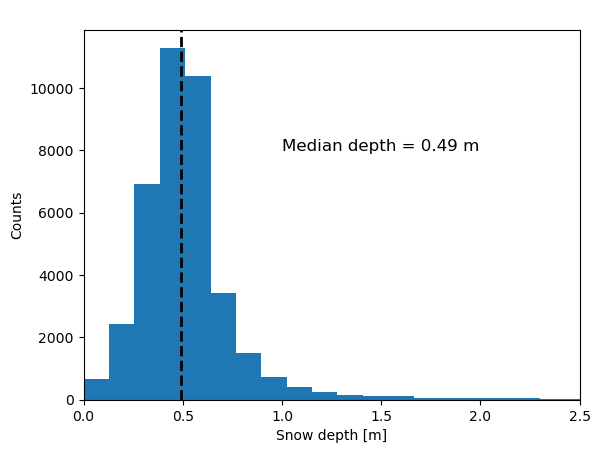

In [13]:
# Calculate median snow depth over the scene
median_depth = difference.where(difference>=0).median()

# Make histogram plot of snow depth
fig, ax = plt.subplots()
difference.where(difference>=0).plot.hist(ax=ax, bins=50)
ax.axvline(x=median_depth, color='black', linewidth=2, linestyle='--') # Median depth line
ax.set_xlim([0, 2.5])
ax.set_ylabel("Counts")
ax.set_xlabel("Snow depth [m]")
ax.set_title(' ')
ax.text(1, 8000, f'Median depth = {median_depth:.2f} m', fontsize=12)

# Multiple Scans Example

For the multiple scans example, we'll work with data from several sites across Bonanza Creek. The files are pre-selected and hosted on S3 for convenient streaming without authentication.

In [14]:
# Define file lists for multiple scan example
# Using cross-section (CRS) sites and control sites (DEC, CRE) that have both snow-on and snow-off data
snow_on_files = [
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230313_CRS1_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230315_CRS2_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230315_CRS3_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230314_CRS4_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230310_CRS5_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230310_CRS6_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230314_CRS7_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_N_20230316_DEC_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20230315_CRE_V01.0.tif",
]

snow_off_files = [
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221026_CRS1_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221026_CRS2_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221025_CRS3_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221025_CRS4_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221025_CRS5_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221024_CRS6_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221024_CRS7_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_N_20221023_DEC_V01.0.tif",
    f"{S3_BASE_URL}/SNEX23_BCEF_TLS_SW_20221027_CRE_V01.0.tif",
]

print(f"Found {len(snow_on_files)} snow-on files")
print(f"Found {len(snow_off_files)} snow-off files")

Found 9 snow-on files
Found 9 snow-off files


In [15]:
# Create list of snow-on DataArrays by streaming from S3
snow_on_rasters = [rxr.open_rasterio(f) for f in snow_on_files]

# Create list of snow-off DataArrays
snow_off_rasters = [rxr.open_rasterio(f) for f in snow_off_files]

print(f"Loaded {len(snow_on_rasters)} snow-on rasters")
print(f"Loaded {len(snow_off_rasters)} snow-off rasters")

Loaded 9 snow-on rasters
Loaded 9 snow-off rasters


To make the final plot of this example cleaner, we will assign each TLS scan a label based on the site ID at Bonanza Creek.

In [16]:
snon_site_ids = []
snoff_site_ids = []

# Get site IDs for each snow-on file from URL
for url in snow_on_files:
    # Extract filename from URL
    filename = url.split('/')[-1]
    # Use regex to extract the site ID from filename, given pattern _SW_YYYYMMDD_SITEID_V
    m = re.search(r'_(SW|N|NE)_\d{8}_(.*?)_V', filename)
    if m:
        snon_site_ids.append(m.group(2))
    else:
        snon_site_ids.append("unknown")

# Get site IDs for each snow-off file
for url in snow_off_files:
    filename = url.split('/')[-1]
    m = re.search(r'_(SW|N|NE)_\d{8}_(.*?)_V', filename)
    if m:
        snoff_site_ids.append(m.group(2))
    else:
        snoff_site_ids.append("unknown")

print("Snow-on site IDs:", snon_site_ids)
print("Snow-off site IDs:", snoff_site_ids)

Snow-on site IDs: ['CRS1', 'CRS2', 'CRS3', 'CRS4', 'CRS5', 'CRS6', 'CRS7', 'DEC', 'CRE']
Snow-off site IDs: ['CRS1', 'CRS2', 'CRS3', 'CRS4', 'CRS5', 'CRS6', 'CRS7', 'DEC', 'CRE']


In [17]:
# Add site ID to attributes of DataArrays
for r, site in zip(snow_on_rasters, snon_site_ids):
    r.attrs['site_id'] = site

for r, site in zip(snow_off_rasters, snoff_site_ids):
    r.attrs['site_id'] = site

In [18]:
# Create dictionaries linking each DataArray to a site ID
snow_on_dict = {r.attrs['site_id']: r for r in snow_on_rasters}
snow_off_dict = {r.attrs['site_id']: r for r in snow_off_rasters}

Now each TLS scan is linked to a site ID. However, we can see that the snow-on data has many more scans than the snow-off data. Because snow depth data is our priority, we will only consider snow-on scans that share a site ID with the snow-off data.

In [19]:
# Determine site IDs with recorded data for both snow-off and snow-on season
common_site_ids = sorted(set(snow_on_dict).intersection(snow_off_dict))
print("Common site IDs:", common_site_ids)

Common site IDs: ['CRE', 'CRS1', 'CRS2', 'CRS3', 'CRS4', 'CRS5', 'CRS6', 'CRS7', 'DEC']


In [20]:
# Create lists of DataArrays for the common sites only
snow_on_paired = [snow_on_dict[sid] for sid in common_site_ids]
snow_off_paired = [snow_off_dict[sid] for sid in common_site_ids]

Now that the site IDs are matched, deriving snow depth is the same as the first example, only with looping to make the calculation (and plotting) easier.

In [21]:
snow_depths = []
# Interpolate DataArrays and derive snow depth, as before
for so, soff, site in zip(snow_on_paired, snow_off_paired, common_site_ids):
    # Interpolate snow-on data onto the x/y grid of snow-off data
    tmp_interp = so.interp(
        x=soff.x,
        y=soff.y,
    )

    tmp_diff = tmp_interp - soff
    tmp_diff.attrs['site_id'] = site

    tmp_diff = tmp_diff.where((tmp_diff[0]>0)&(tmp_diff[0]<=2))
    snow_depths.append(tmp_diff)

Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20230315_CRE_V01.0.tif.msk: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20230315_CRE_V01.0.tif.MSK: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20221027_CRE_V01.0.tif.msk: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20221027_CRE_V01.0.tif.MSK: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20221027_CRE_V01.0.tif.msk: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20221027_CRE_V01.0.tif.MSK: 403
Warning 1: HTTP response code on https://snowex-tutorials.s3.us-west-2.amazonaws.com/tls/SNEX23_BCEF_TLS_SW_20230313_CRS1_V01.0.tif.msk: 403
Warning 1: HTTP res

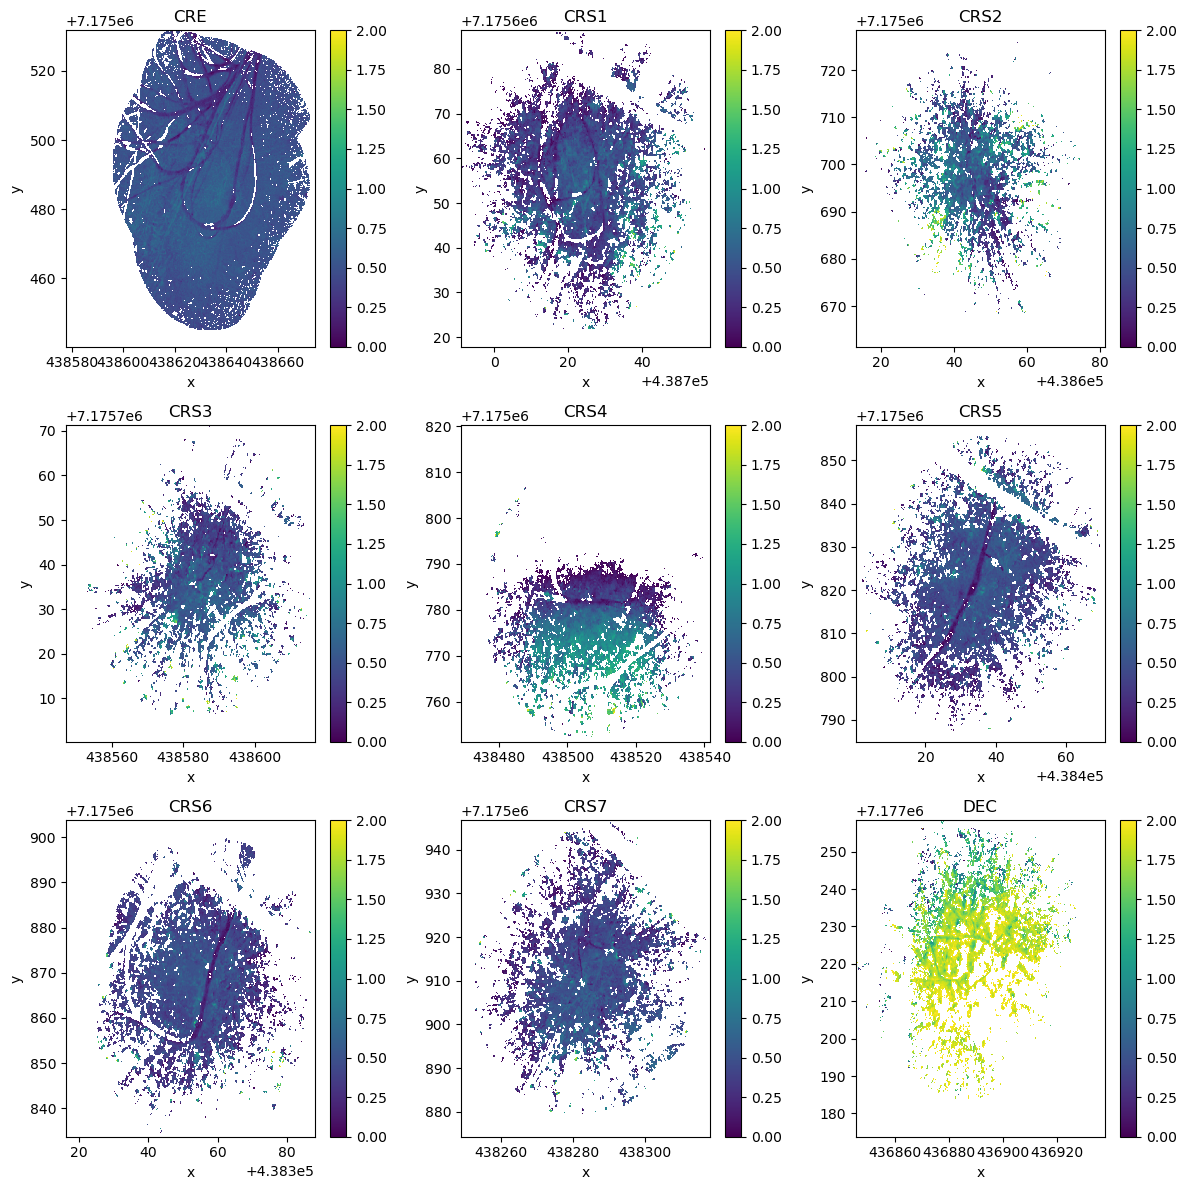

In [22]:
# Plot the derived snow depths in a 3x3 figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, data_array in enumerate(snow_depths):
    data_array.plot(ax=axes[idx], vmin=0, vmax=2)
    axes[idx].set_title(f"{snow_depths[idx].attrs['site_id']}")

plt.tight_layout()
plt.show()

That's all there is to it! Some of the coverage is a bit sparse, and the depths over some sites look variable, but we have reasonable snow depths over 9 sites in Bonanza Creek. These could then be compared to other ground based efforts or airborne data to cross-calibrate observation methods.

## Working with the Full Dataset Using earthaccess

This tutorial uses a subset of TLS data hosted on S3 for convenience and to avoid authentication requirements in automated builds. If you want to access the complete dataset from NSIDC or explore additional dates and locations, you can use the `earthaccess` package.

### Installation

First, install earthaccess if you haven't already:

```bash
pip install earthaccess
```

or 

```bash
conda install -c conda-forge earthaccess
```

### Authentication and Data Access

```python
import earthaccess

# Authenticate with NASA Earthdata Login
# On first use, you'll be prompted for your Earthdata credentials
# or you can set EARTHDATA_USERNAME and EARTHDATA_PASSWORD environment variables
auth = earthaccess.login(strategy="interactive")

# Search for TLS data by DOI and date range
results = earthaccess.search_data(
    doi="10.5067/R466GRXNA61S",  # SnowEx 2023 Bonanza Creek TLS dataset
    temporal=('2022-10-01', '2023-03-31'),  # Full campaign period
)

print(f"Found {len(results)} granules")

# Option 1: Stream data directly (no download needed)
files = earthaccess.open(results)
snow_data = rxr.open_rasterio(files[0])

# Option 2: Download data locally
downloaded_files = earthaccess.download(results, "./data")
```

### Key Points

- **Authentication**: You'll need a free NASA Earthdata Login account (register at https://urs.earthdata.nasa.gov/)
- **Strategy options**: 
  - `strategy="interactive"` - Best for local development, prompts for credentials
  - `strategy="environment"` - Reads credentials from environment variables (good for automated workflows)
- **Data streaming**: `earthaccess.open()` allows you to work with data without downloading
- **Search options**: You can filter by temporal range, bounding box, and other parameters

### Dataset Information

- **Dataset**: SnowEx 2023 Bonanza Creek Terrestrial Laser Scanning (TLS)
- **DOI**: 10.5067/R466GRXNA61S
- **NSIDC Page**: https://nsidc.org/data/snex23_bcef_tls
- **Temporal Coverage**: October 2022 (snow-off) and March 2023 (snow-on)
- **Spatial Coverage**: Bonanza Creek Experimental Forest, Alaska
- **Sites**: Cross-section transects (CRS1-20), control sites (DEC, CRE, SPR)

For more information about the earthaccess package, visit: https://earthaccess.readthedocs.io/